# Model creation notebook
This notebook countains all info about building the ML models to predict temperature and CO2 emissions. Note that 4 models will be used in this notebook :  linear regression,lasso regression, polynomial regression and Support Vector Machine Regressor



# Libraries importation 

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn import svm
import pandas as pd


# Meteo dataset importation and exploring normal distribution of the unscalled data
Now we are importing the meteo dataset and exploring how is the distribution if we don't yet scale the data

/tmp/ipykernel_8514/3800929642.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected["mean_temperature"] = (selected["Tmax(°C)"]+selected["Tmin(°C)"])/2


Text(0.5, 0, 'unscalled normal distribution of temperature')

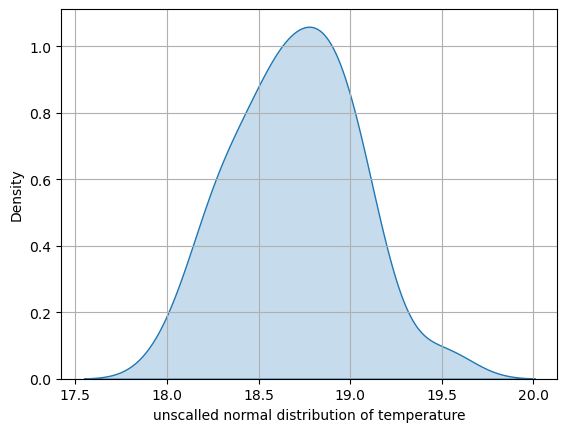

In [2]:
meteo = pd.read_excel("mto.xlsx")
meteo = meteo.dropna()
selected = meteo[["date","Tmin(°C)","Tmax(°C)"]]
selected["mean_temperature"] = (selected["Tmax(°C)"]+selected["Tmin(°C)"])/2
temperature = selected["mean_temperature"].groupby(by = selected["date"].dt.year).mean()
plt.grid()
sns.kdeplot(x = temperature,fill = True)
plt.xlabel("unscalled normal distribution of temperature")

As we can see major parts of the temperature dataset are located between 18°C and 19.5 °C

# Greenhouse Dataset importation
Now we are doing the same for CO2 greenhouse gaz 

Text(0.5, 0, 'Unscalled normal distribution of CO2 emission ')

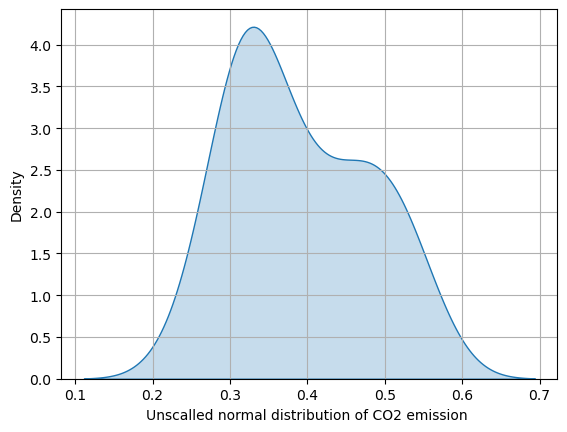

In [3]:

ghg = pd.read_csv("ghg.csv")
meteo = meteo.dropna()
indexes = np.arange(1993,2023).astype("str")
population  = 3.5 #this is the average population number of the analamanga region
emissions =((np.array(ghg[indexes]).T)*3.5).reshape((30,))
plt.grid()
sns.kdeplot(x = emissions,fill = True)
plt.xlabel("Unscalled normal distribution of CO2 emission ")

# Scalling function 
Now we are scalling the datasets with standarization

In [4]:
def scale(train,test):
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(train)
    x_test_scaled = scaler.transform(test)
    return {"train_scaled":x_train_scaled,"test_scaled":x_test_scaled}

# Plotting scalled data thourgh kfold cross validation

Here is the representation of the distribution of CO2 scalled

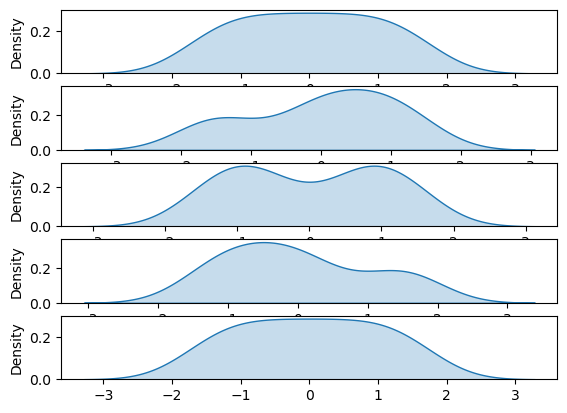

In [5]:
cv = KFold(n_splits=5) 
for i,(train,test) in enumerate(cv.split(emissions)):
    plt.subplot(5,1,i+1)
    sns.kdeplot(x = np.array(scale(np.array(train).reshape((24,1)),np.array(test).reshape((6,1)))["train_scaled"]).reshape((24,)),fill = True)

# Building linear regression model
Now we are building a linear regression model to predict temperature thourgh co2 emission data

Mean r² of the model :0.30769872867640524
Mean RMSE of the model : 0.5206206273973792°C
Std of the score : 0.1408724428542974
std of the error : 0.13119133101397373°C


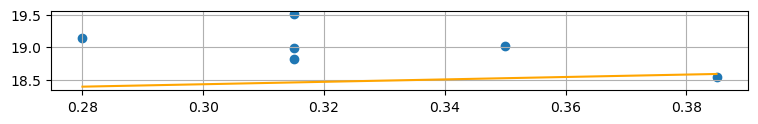

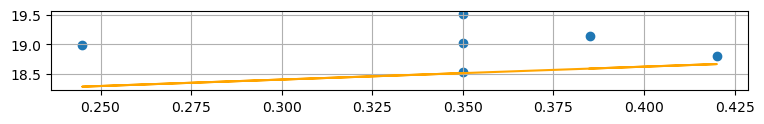

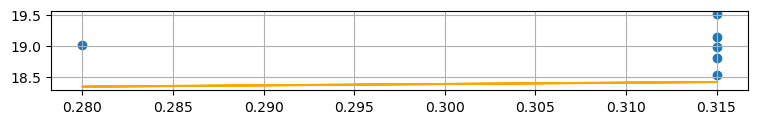

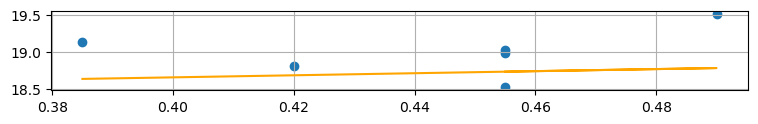

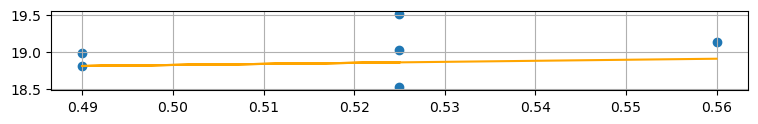

In [6]:
total_score = []
cv = KFold(n_splits=5) 
score = []
rmse = []
for i,(train,test) in enumerate(cv.split(emissions)):
    train = np.array(emissions[train[0:]]).reshape((24,1))
    test = np.array(emissions[test[0:]]).reshape((6,1))
    model = LinearRegression()
    model.fit(np.array(scale(train,test)["train_scaled"]).reshape((24,1)),temperature[0:24])
    score.append(model.score(np.array(scale(train,test)["train_scaled"]).reshape((24,1)),temperature[0:24]))
    predicted = model.predict(scale(train,test)["test_scaled"])
    mse = mean_squared_error(predicted,temperature[24:])
    rmse.append(np.sqrt(mse))
    plt.figure(figsize = (9,6))
    plt.subplot(5,1,i+1)
    plt.grid()
    plt.scatter(test.reshape((6,)) ,temperature[24:])
    plt.plot(test.reshape((6,)),predicted,color = "orange")

    

    
print(f"Mean r² of the model :{np.mean(score)}")
print(f"Mean RMSE of the model : {np.mean(rmse)}°C")
print(f"Std of the score : {np.std(score)}")
print(f"std of the error : {np.std(rmse)}°C")
total_score.append(np.mean(score))


As we can see, the linear regression model have an accuracy of 30%, it predicted 30% of the data, and thos accuracy may vary to 14% each 6 years. And the error may vary to 0.13°C.

# adding and building lasso regression model
After testing a linear regression model with an accuracy equal to 50%, let's now test lasso regression and find if it's more accurate for our dataset.

We start by using nested cross validation to evalute the best alpha hyperparameter to the model.

Accuracy of the lasso regression model : 0.30769872867628034
best parameters :{'alpha': 1e-07}
Standard deviation of the score : 0.14087244285429704


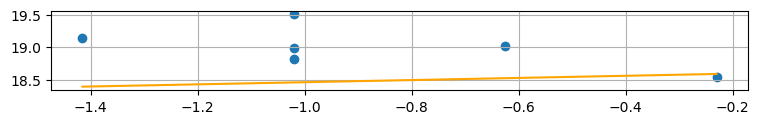

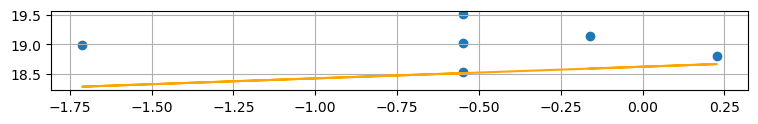

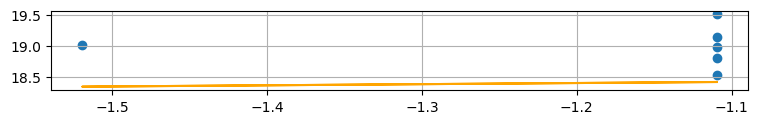

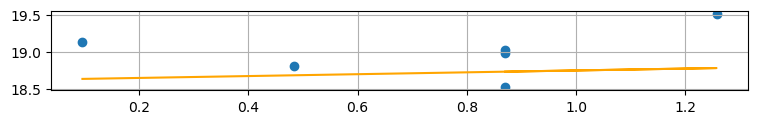

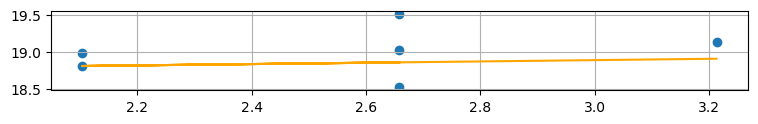

In [11]:
params = {"alpha":[10**-7,0.0000001,0.00001,0.0001,0.001,0.01,0.1,1,10]}
inner_cv = GridSearchCV(estimator = Lasso(),param_grid=params,cv = 5)
inner_cv.fit(X = emissions.reshape((30,1)),y = temperature)
outer_cv = KFold(n_splits = 5)
scores = []
for i,(train,test) in enumerate(outer_cv.split(emissions.reshape((30,1)))):
    x = scale(np.array(emissions[train[0:]]).reshape((24,1)),np.array(emissions[test[0:]]).reshape((6,1)))["train_scaled"]
    x_test = scale(np.array(emissions[train[0:]]).reshape((24,1)),np.array(emissions[test[0:]]).reshape((6,1)))["test_scaled"]
    model = Lasso(alpha = inner_cv.best_params_["alpha"])
    model.fit(np.array(x).reshape((24,1)),temperature[:24])
    scores.append(model.score(np.array(x).reshape((24,1)),temperature[:24]))
    predicted = model.predict(x_test)
    plt.figure(figsize = (9,6))
    plt.subplot(5,1,i+1)
    plt.grid()
    plt.scatter(x_test.reshape((6,)) ,temperature[24:])
    plt.plot(x_test.reshape((6,)),predicted,color = "orange")
    
    
print(f"Accuracy of the lasso regression model : {np.mean(scores)}")
print(f"best parameters :{inner_cv.best_params_}")
print(f"Standard deviation of the score : {np.std(scores)}")
total_score.append(np.mean(scores))

As we can see, the score is really similar to linear regression, with an accuracy that can increase or decrease by 14% each 6 years.

Now let's try polynomial regression.

Best degree :{'poly__degree': 2}
Accuracy of the polynomial regression model :0.3353546943508351
Standard deviation of the score : 0.1351165739385441


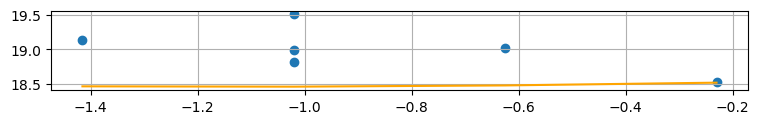

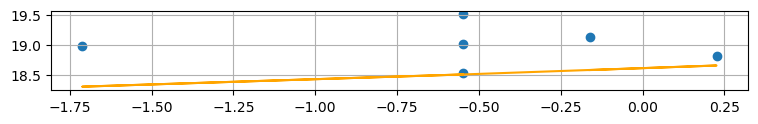

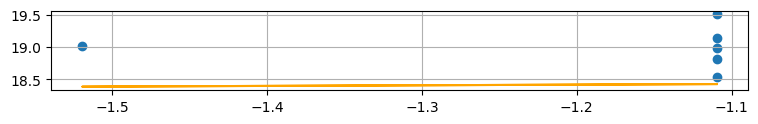

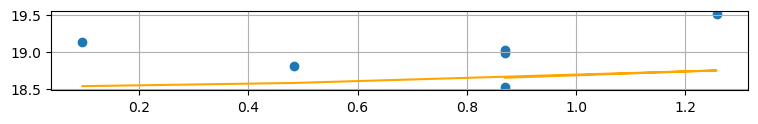

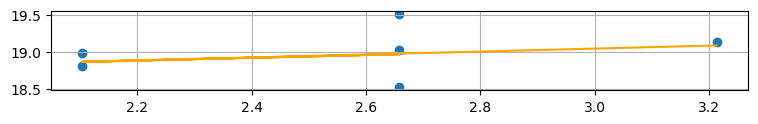

In [20]:
# pipeline creation for transforming into polynomial features
pipeline = Pipeline([("poly",PolynomialFeatures(include_bias=False)),
    ("linreg",LinearRegression())
])

params = {"poly__degree":[2,3,4,5,6,7,8,9,10]}
inner_cv = GridSearchCV(estimator = pipeline,param_grid = params,cv = 5)
inner_cv.fit(emissions.reshape((30,1)),temperature)
outer_cv = KFold(n_splits = 5)
scores = []
for i,(train,test) in enumerate(outer_cv.split(emissions.reshape((30,1)))):
    x = scale(np.array(emissions[train[0:]]).reshape((24,1)),np.array(emissions[test[0:]]).reshape((6,1)))["train_scaled"]
    x_test = scale(np.array(emissions[train[0:]]).reshape((24,1)),np.array(emissions[test[0:]]).reshape((6,1)))["test_scaled"]
    pipe = PolynomialFeatures(degree = inner_cv.best_params_["poly__degree"],include_bias = False)
    x_train_poly = pipe.fit_transform(np.array(x).reshape((24,1)))
    x_test_poly = pipe.transform(np.array(x_test).reshape((6,1)))
    model = LinearRegression()
    model.fit(x_train_poly,temperature[:24])
    scores.append(model.score(x_train_poly,temperature[:24]))
    predicted = model.predict(x_test_poly)
    plt.figure(figsize = (9,6))
    plt.subplot(5,1,i+1)
    plt.grid()
    plt.scatter(x_test.reshape((6,)) ,temperature[24:])
    plt.plot(x_test.reshape((6,)),predicted,color = "orange")
    
    

print(f"Best degree :{inner_cv.best_params_}")
print(f"Accuracy of the polynomial regression model :{np.mean(scores)}")
print(f"Standard deviation of the score : {np.std(scores)}")
total_score.append(np.mean(scores))

The accuracy is a little bit higher than those of the linear regression and lasso regression, with a standard deviation of 13% which means that this accuracy may increase or decrease by 13% each 6 years.

# Support Vector Machine Regressor model for temperature prediction


best parameters after cross validation : {'C': 35, 'gamma': 1, 'kernel': 'rbf'}
Mean score of the model :0.4042575157956592
Standard deviation of the score : 0.12797898890473983


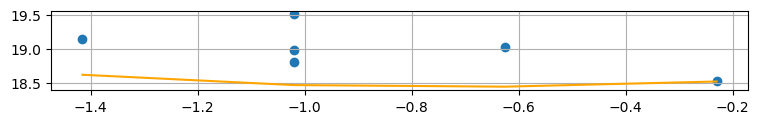

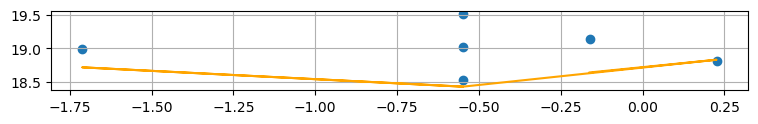

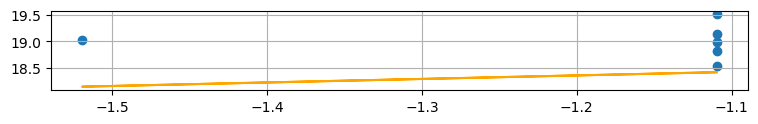

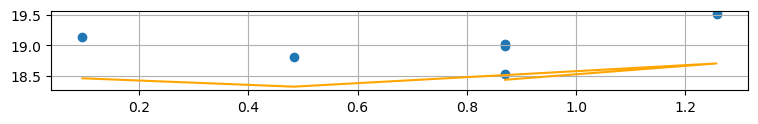

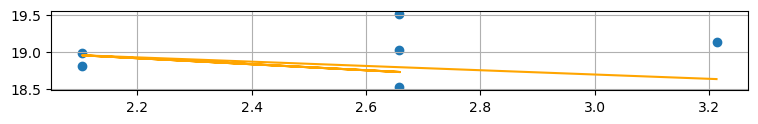

In [16]:
params =   {"gamma":[0.01,0.1,1],"kernel":["rbf","linear"],"C":[20,30,35]}
inner_cv = GridSearchCV(estimator = svm.SVR(),param_grid = params,cv = 5)
inner_cv.fit(emissions.reshape((30,1)),temperature)
print(f"best parameters after cross validation : {inner_cv.best_params_}")
scores = []
cross_val = KFold(n_splits = 5)
for i,(train,test) in enumerate(cross_val.split(emissions.reshape((30,1)))):
    model = svm.SVR(C = inner_cv.best_params_["C"], gamma = inner_cv.best_params_["gamma"], kernel = inner_cv.best_params_["kernel"])
    x = scale(np.array(emissions[train[0:]]).reshape((24,1)),np.array(emissions[test[0:]]).reshape((6,1)))["train_scaled"]
    x_test = scale(np.array(emissions[train[0:]]).reshape((24,1)),np.array(emissions[test[0:]]).reshape((6,1)))["test_scaled"]
    model.fit(x,temperature[:24])
    predicted = model.predict(x_test)
    scores.append(model.score(x,temperature[:24]))
    plt.figure(figsize = (9,6))
    plt.subplot(5,1,i+1)
    plt.grid()
    plt.scatter(x_test.reshape((6,)) ,temperature[24:])
    plt.plot(x_test.reshape((6,)),predicted,color = "orange")
    
print(f"Mean score of the model :{np.mean(scores)}")
print(f"Standard deviation of the score : {np.std(scores)}")
total_score.append(np.mean(scores))

The accuracy is the highest , before linear regression, lasso regression and polynomial regression. This can increase or decrease by 12% each 6 years. It's possible to conclude that SVR is the best model in these 4 models if we refer to accuracy.

Text(0.5, 1.0, 'ML models acuracy for temperature prediction from Carbon Dioxyde dataset')

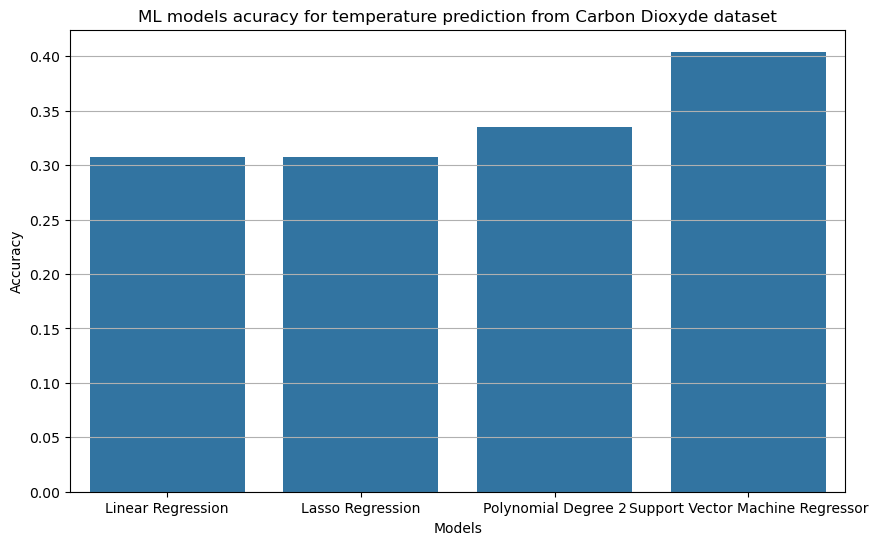

In [10]:

plt.figure(figsize = (10,6))
plt.grid()
sns.barplot(x = ["Linear Regression","Lasso Regression","Polynomial Degree 2","Support Vector Machine Regressor"],y = total_score)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("ML models acuracy for temperature prediction from Carbon Dioxyde dataset")